In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import MDAnalysis.lib.distances
import nglview as nv

_ColormakerRegistry()

In [2]:
#Path to structure and trajectory files
structf = "/Volumes/Akash_SSD/starter_project/ubiquitin/chestnut/unfold_fold/i-3.5/1/indus_fwd.gro"
trajf = "/Volumes/Akash_SSD/starter_project/ubiquitin/chestnut/unfold_fold/i-3.5/1/indus_fwd_mol.xtc"

#Create universe
u = mda.Universe(structf,trajf)
protein = u.select_atoms("protein")

In [3]:
#Visualize using nglview
from nglview.contrib.movie import MovieMaker
view = nv.show_mdanalysis(protein)
movie = MovieMaker(view, output='my.gif', in_memory=True)
movie.make()

IntProgress(value=0, description='Rendering ...', max=200)

# Ubiquitin - atom selections

GROMACS groups: http://manual.gromacs.org/documentation/2019-rc1/reference-manual/analysis/using-groups.html

MDAnalysis selections: Look up documentation.

Looking through the topology file:
- 1st residue - NMET: MET with charged N-terminus (NH3+). N-terminal atom is N. Terminal amide H's are H1, H2, H3 
- Last residue - CGLY: GLY with charged C-terminus (COO-). C-terminal atom is C. Terminal carboxylic O's are OC1, OC2
- Amide nitrogen is N
- Amide hydrogen is H
- Alpha carbons on backbone are CA.
- Alpha hydrogen is HA (for GLY, HA1 and HA2)
- Acid carbons on backbone are C.
- Acid oxygens on backbone are O.

In [4]:
#   H HA O
#   | |  "
#-(-N-CA-C-)-
#     |
#     R

In [5]:
print(len(protein))
#GROMACS make_ndx: 1231

1231


In [6]:
protein_heavy = u.select_atoms("protein and not type H")
print(len(protein_heavy))
#GROMACS make_ndx Protein-H: 602 

602


In [7]:
C_alpha = u.select_atoms ("protein and name CA")
print(len(C_alpha))
#GROMACS make_ndx C-alpha: 76

76


In [8]:
# In MDAnalysis N, CA, C, O are backbone
mda_backbone = u.select_atoms("backbone")
alt_mda_backbone = u.select_atoms("name CA or name C or name N or name O")
print(len(mda_backbone))
print(len(alt_mda_backbone)) #same

# In GROMACS, N, CA and C are backbone
backbone = u.select_atoms("name CA or name C or name N")
print(len(backbone))

#GROMACS make_ndx: 228

303
303
228


In [9]:
# In GROMACS, all atoms except N, CA, C, O, backbone amide hydrogens, 
# oxygens in C-terminus and hydrogens on the N-terminus are side chain atoms
side_chain = u.select_atoms("""protein and not (name N or name CA or name C or name O or name H
                            or name H1 or name H2 or name H3 or name OC1 or name OC2)""")
print(len(side_chain))

#GROMACS make_ndx SideChain: 851

851


In [10]:
# In GROMACS, protein side chain excluding all H is side_chain_heavy
side_chain_heavy = u.select_atoms("""protein and not(name N or name CA or name C or name O 
                                     or name OC1 or name OC2 or type H)""")
print(len(side_chain_heavy))

#GROMACS make_ndx SideChain-H = 297

297


In [11]:
# O's and terminal O's excluded from GROMACS backbone
backbone_oxygens = u.select_atoms("name O or name OC1 or name OC2")
print(len(backbone_oxygens))

77


In [12]:
assert(len(backbone) + len(backbone_oxygens) + len(side_chain_heavy) == len(protein_heavy))
#228 + 77 + 297 = 602

# Native Contacts in reference structure (1UBQ PDB)

Determine number of contacts between side-chain heavy atoms belonging to residues $i$ and $j$ such that $|i - j| > 3$ and the distance between the atoms is < $4.5 \mathring{\textrm{A}}$ 

In [13]:
refu = mda.Universe("/Volumes/Akash_SSD/starter_project/ubiquitin/local/equil/1UBQ.pdb")
refprotein = refu.select_atoms("protein")

In [14]:
side_heavy_sel = "protein and not(name N or name CA or name C or name O or name OC1 or name OC2 or type H)"

In [15]:
%%time
#Method 1: Explicit loops
def dist(coordsi, coordsj, box):
    #PBC distance calculation
    dx = coordsi - coordsj
    return np.sqrt(min(dx[0],box[0]-dx[0])**2 + min(dx[1],box[1]-dx[1])**2 + min(dx[2],box[2]-dx[2])**2)

nres = len(refprotein.residues)
box = u.dimensions

refcontacts = 0

for i in range(nres):
    heavy_side_i = refprotein.residues[i].atoms.select_atoms(side_heavy_sel)
    heavy_side_j = refprotein.residues[i+4:].atoms.select_atoms(side_heavy_sel)
    for m in heavy_side_i:
        for n in heavy_side_j:
            if dist(m.position, n.position, box) < 4.5:
                refcontacts += 1
                        
print(refcontacts)

286
CPU times: user 1.59 s, sys: 27.5 ms, total: 1.62 s
Wall time: 1.72 s


In [16]:
%%time
#Method 2: Faster distance calculation using MDAnalysis library function
nres = len(refprotein.residues)
box = u.dimensions

refcontacts = 0

for i in range(nres):
    heavy_side_i = refprotein.residues[i].atoms.select_atoms(side_heavy_sel)
    heavy_side_j = refprotein.residues[i+4:].atoms.select_atoms(side_heavy_sel)
    da = mda.lib.distances.distance_array(heavy_side_i.positions, heavy_side_j.positions, box)
    refcontacts += np.count_nonzero(da < 4.5)
        
print(refcontacts)

286
CPU times: user 414 ms, sys: 13.5 ms, total: 428 ms
Wall time: 499 ms


# Contact analysis along trajectory

In [17]:
%%time
# Method 1

def dist(coordsi, coordsj, box):
    #PBC distance calculation
    dx = coordsi - coordsj
    return np.sqrt(min(dx[0],box[0]-dx[0])**2 + min(dx[1],box[1]-dx[1])**2 + min(dx[2],box[2]-dx[2])**2)

skip = 1
nres = len(protein.residues)

step = 0
contacts = []

for ts in u.trajectory[0::skip]:
    #Method 2
    box = ts.dimensions
    ncontacts = 0

    for i in range(nres):
        heavy_side_i = protein.residues[i].atoms.select_atoms("protein and not(backbone or type H)")
        heavy_side_j = protein.residues[i+4:].atoms.select_atoms("protein and not(backbone or type H)")
        for m in heavy_side_i:
            for n in heavy_side_j:
                if dist(m.position, n.position, box) < 4.5:
                    ncontacts += 1
        
    print("Step = {}, time = {} ps, contacts = {}".format(step*skip + 1,ts.time,ncontacts))
    contacts.append([ts.time, ncontacts])
    step += 1

contacts_1 = np.array(contacts)

Step = 1, time = 0.0 ps, contacts = 266
Step = 2, time = 10.0 ps, contacts = 236
Step = 3, time = 20.0 ps, contacts = 222
Step = 4, time = 30.0 ps, contacts = 196
Step = 5, time = 40.0 ps, contacts = 200
Step = 6, time = 50.0 ps, contacts = 191
Step = 7, time = 60.0 ps, contacts = 188
Step = 8, time = 70.0 ps, contacts = 190
Step = 9, time = 80.0 ps, contacts = 177
Step = 10, time = 90.0 ps, contacts = 188
Step = 11, time = 100.0 ps, contacts = 189
Step = 12, time = 110.0 ps, contacts = 187
Step = 13, time = 120.0 ps, contacts = 195
Step = 14, time = 130.0 ps, contacts = 179
Step = 15, time = 140.0 ps, contacts = 159
Step = 16, time = 150.0 ps, contacts = 141
Step = 17, time = 160.0 ps, contacts = 154
Step = 18, time = 170.0 ps, contacts = 147
Step = 19, time = 180.0 ps, contacts = 140
Step = 20, time = 190.0 ps, contacts = 149
Step = 21, time = 200.0 ps, contacts = 128
Step = 22, time = 210.0 ps, contacts = 131
Step = 23, time = 220.0 ps, contacts = 125
Step = 24, time = 230.0 ps, con

Step = 195, time = 1940.0 ps, contacts = 0
Step = 196, time = 1950.0 ps, contacts = 0
Step = 197, time = 1960.0 ps, contacts = 0
Step = 198, time = 1970.0 ps, contacts = 0
Step = 199, time = 1980.0 ps, contacts = 0
Step = 200, time = 1990.0 ps, contacts = 0
Step = 201, time = 2000.0 ps, contacts = 0
CPU times: user 5min 10s, sys: 5.53 s, total: 5min 15s
Wall time: 5min 12s


In [18]:
%%time
# Method 2

skip = 1
nres = len(protein.residues)

step = 0
contacts = []

for ts in u.trajectory[0::skip]:
    #Method 2
    box = ts.dimensions
    ncontacts = 0

    for i in range(nres):
        heavy_side_i = protein.residues[i].atoms.select_atoms("protein and not(backbone or type H)")
        heavy_side_j = protein.residues[i+4:].atoms.select_atoms("protein and not(backbone or type H)")
        da = mda.lib.distances.distance_array(heavy_side_i.positions, heavy_side_j.positions, box)
        ncontacts += np.count_nonzero(da < 4.5)
        
    print("Step = {}, time = {} ps, contacts = {}".format(step*skip + 1,ts.time,ncontacts))
    contacts.append([ts.time, ncontacts])
    step += 1

contacts_2 = np.array(contacts)

Step = 1, time = 0.0 ps, contacts = 266
Step = 2, time = 10.0 ps, contacts = 236
Step = 3, time = 20.0 ps, contacts = 222
Step = 4, time = 30.0 ps, contacts = 196
Step = 5, time = 40.0 ps, contacts = 200
Step = 6, time = 50.0 ps, contacts = 191
Step = 7, time = 60.0 ps, contacts = 188
Step = 8, time = 70.0 ps, contacts = 190
Step = 9, time = 80.0 ps, contacts = 177
Step = 10, time = 90.0 ps, contacts = 188
Step = 11, time = 100.0 ps, contacts = 189
Step = 12, time = 110.0 ps, contacts = 187
Step = 13, time = 120.0 ps, contacts = 195
Step = 14, time = 130.0 ps, contacts = 179
Step = 15, time = 140.0 ps, contacts = 159
Step = 16, time = 150.0 ps, contacts = 141
Step = 17, time = 160.0 ps, contacts = 154
Step = 18, time = 170.0 ps, contacts = 147
Step = 19, time = 180.0 ps, contacts = 140
Step = 20, time = 190.0 ps, contacts = 149
Step = 21, time = 200.0 ps, contacts = 128
Step = 22, time = 210.0 ps, contacts = 131
Step = 23, time = 220.0 ps, contacts = 125
Step = 24, time = 230.0 ps, con

Step = 195, time = 1940.0 ps, contacts = 0
Step = 196, time = 1950.0 ps, contacts = 0
Step = 197, time = 1960.0 ps, contacts = 0
Step = 198, time = 1970.0 ps, contacts = 0
Step = 199, time = 1980.0 ps, contacts = 0
Step = 200, time = 1990.0 ps, contacts = 0
Step = 201, time = 2000.0 ps, contacts = 0
CPU times: user 1min 21s, sys: 549 ms, total: 1min 21s
Wall time: 1min 21s


In [19]:
assert(np.allclose(contacts_1, contacts_2))

(0, 279.3)

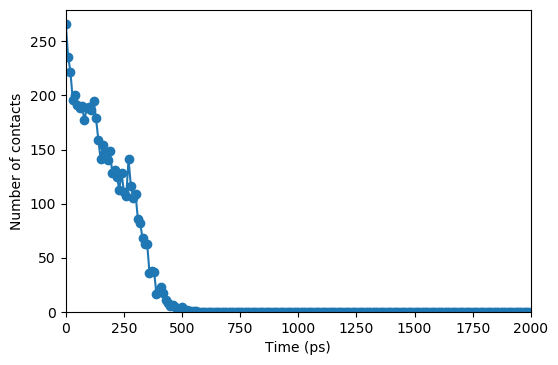

In [20]:
plt.figure(dpi=100)
ax = plt.gca()
ax.plot(contacts_2[:,0], contacts_2[:,1], 'o-')
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Number of contacts")
ax.set_xlim([min(contacts_2[:,0]), max(contacts_2[:,0])])
ax.set_ylim([0, None])

(0, 1)

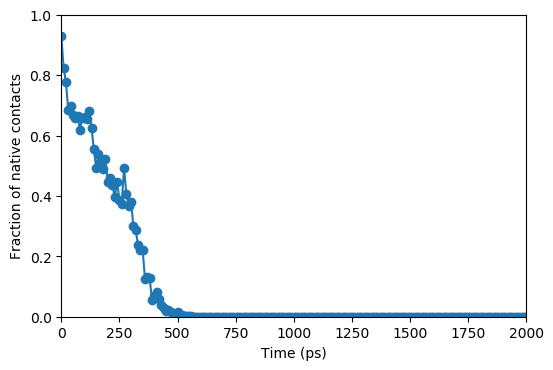

In [21]:
plt.figure(dpi=100)
ax = plt.gca()
ax.plot(contacts_2[:,0], contacts_2[:,1]/refcontacts, 'o-')
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Fraction of native contacts")
ax.set_xlim([min(contacts_2[:,0]), max(contacts_2[:,0])])
ax.set_ylim([0, 1])